In [2]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
import torch
import torch.nn as nn

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

from collections import Counter

cwd = os.getcwd()
cwd

'C:\\Users\\LSB\\Desktop\\넥토리얼_분석가과제'

In [3]:
data_dir = os.path.join(cwd, 'UX선행기획팀')

output = pd.read_csv(os.path.join(data_dir, 'output_sample.csv'))
output

,A게임 유저ID,B게임 플레이시 한달간 누적 플레이 예측 시간(분),B게임 플레이시 열성적인 플레이어가 될 확률,C게임 플레이시 한달간 누적 플레이 예측 시간(분),C게임 플레이시 열성적인 플레이어가 될 확률


# Read datasets

In [4]:
## Read data item description
#did = pd.read_excel(os.path.join(data_dir, '과제 데이터 명세.xlsx'), engine='openpyxl') 
did = pd.read_excel('C:\\Users\\LSB\\Desktop\\넥토리얼_분석가과제\\UX선행기획팀\\과제 데이터 명세.xlsx', engine='openpyxl') 

did_map ={}
for i in range(len(did)):
    did_map[did.loc[i,'컬럼명']] = did.loc[i,'컬럼설명']

## Read game datasets
game_A = pd.read_csv(os.path.join(data_dir, 'game_A.csv'))
game_B = pd.read_csv(os.path.join(data_dir, 'game_B.csv'))
game_C = pd.read_csv(os.path.join(data_dir, 'game_C.csv'))

print("data size")
print('game_A', game_A.shape)
print('game_B', game_B.shape)
print('game_C', game_C.shape)


## Create id list
user_A = set(game_A['id'])
user_B = set(game_B['id'])
user_C = set(game_C['id'])

user_AnB = set(game_A['id']) & set(game_B['id'])
user_AnC = set(game_A['id']) & set(game_C['id'])

print("No. of game A user:", len(user_A))
print("No. of game B user:", len(user_B))
print("No. of game C user:", len(user_C))
print("\nNo. of game A and B user:", len(user_AnB))
print("No. of game A and C user:", len(user_AnC))

data size
game_A (1570454, 16)
game_B (160677, 16)
game_C (409155, 11)
No. of game A user: 113408
No. of game B user: 14863
No. of game C user: 86183

No. of game A and B user: 921
No. of game A and C user: 8957


# Create New Data

In [4]:
# Convert 'sdate' feature to datetime type.
game_A['sdate'] = pd.to_datetime(game_A['sdate'])
game_B['sdate'] = pd.to_datetime(game_B['sdate'])
game_C['sdate'] = pd.to_datetime(game_C['sdate'])

game_A = game_A.sort_values(by='sdate', ascending=True)
game_B = game_B.sort_values(by='sdate', ascending=True)
game_C = game_C.sort_values(by='sdate', ascending=True)

features = ['on_count']
for col in game_A.columns:
    if (col != 'sdate') & (col != 'id'):
        features.append(str("cum_"+col))
        
features.append('weekday_cum_playtime')
features.append('weekend_cum_playtime')
features.append('total_cum_playtime_B')
features.append('total_cum_playtime_C')

df_A = pd.DataFrame(np.nan, index=user_A, columns=features)

# Compute weekdays & week-end average play time(apt) in game A
# Compute  cumulative play time(cpt) and average play time(apt) in game A
weekday = game_A.loc[game_A['sdate'].dt.weekday < 5]
weekend = game_A.loc[game_A['sdate'].dt.weekday >= 5]
wd_apt = pd.DataFrame(weekday['totalplaytime'].groupby(weekday['id']).sum())
we_apt = pd.DataFrame(weekend['totalplaytime'].groupby(weekend['id']).sum())
weekday_users = list(set(weekday['id']))
weekend_users = list(set(weekend['id']))

for _id in tqdm(weekday_users):
    df_A.loc[_id, 'weekday_cum_playtime'] = wd_apt.loc[_id][0]
    
for _id in tqdm(weekend_users):
    df_A.loc[_id, 'weekend_cum_playtime'] = we_apt.loc[_id][0]
    
for col in game_A:
    if col == 'id':
        pass
    elif col == 'sdate':
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).count())
        print('on_count')
        for _id in tqdm(user_A):
            df_A.loc[_id, 'on_count'] = D.loc[_id][0]
    else:
        feat = str('cum_'+col)
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).sum())
        print(feat)
        for _id in tqdm(user_A):
            if pd.isna(D.loc[_id,:])[0] == True:
                df_A.loc[_id, feat] = 0.0
            else:
                df_A.loc[_id, feat] = D.loc[_id][0]

game_B_cumPlaytime = pd.DataFrame(game_B['totalplaytime'].groupby(game_B['id']).sum())
for _id in tqdm(user_AnB):
    df_A.loc[_id, 'total_cum_playtime_B'] = game_B_cumPlaytime.loc[_id][0]
    
game_C_cumPlaytime = pd.DataFrame(game_C['totalplaytime'].groupby(game_C['id']).sum())
for _id in tqdm(user_AnC):
    df_A.loc[_id, 'total_cum_playtime_C'] = game_C_cumPlaytime.loc[_id][0]

allday_player = set(df_A[df_A['on_count'] >= 31.0].index)
for _id in tqdm(user_A):
    if _id in allday_player:
        df_A.loc[_id, 'is_allday_player'] = 1.0
    else:
        df_A.loc[_id, 'is_allday_player'] = 0.0

 37%|███████████████████████████▎                                             | 38646/103093 [00:05<00:08, 7655.50it/s]


KeyboardInterrupt: 

In [5]:
# Add day averaged value
for col in df_A.columns:
    if col.startswith('cum_'):
        df_A[str("avg_"+col[4:])] = df_A[col]/df_A['on_count']
        
df_A['weekday_day_playtime'] = df_A['weekday_cum_playtime']/df_A['on_count']
df_A['weekend_day_playtime'] = df_A['weekend_cum_playtime']/df_A['on_count']

In [6]:
if ('passionate_B' in df_A.columns) or ('passionate_C' in df_A.columns):
    df_A = df_A.drop(['passionate_B', 'passionate_C'], axis=1)
    
#B_users = df_A[df_A['total_cum_playtime_B'] > 0.0].copy()
#C_users = df_A[df_A['total_cum_playtime_C'] > 0.0].copy()

# Cumulative Play time top 75% user id list
#likeB_id = df_A[df_A['total_cum_playtime_B'] >= B_users['total_cum_playtime_B'].quantile(.75)].index
#likeC_id = df_A[df_A['total_cum_playtime_C'] >= C_users['total_cum_playtime_C'].quantile(.75)].index

likeB_id = df_A[df_A['total_cum_playtime_B'] >= df_A.loc[user_AnB, 'total_cum_playtime_B'].quantile(.75)].index
likeC_id = df_A[df_A['total_cum_playtime_C'] >= df_A.loc[user_AnC, 'total_cum_playtime_C'].quantile(.75)].index

# Assign label 1 to Cumulative Play time top 10% users, else 0.
df_A.loc[likeB_id, 'passionate_B'] = 1
df_A.loc[likeC_id, 'passionate_C'] = 1

In [7]:
A = df_A.replace(np.nan, 0)
A.describe()

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_quest_count,avg_look_count,avg_npc_count,avg_party_count,avg_bosskill_count,avg_mail_count,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C
count,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,1.134080e+05,113408.000000,113408.000000,113408.000000,113408.000000,...,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000
mean,13.847824,4556.035421,42.856906,2767.885423,389.892741,2.421608e+04,1928.229164,888.575206,54.865159,2388.450427,...,103.667434,0.445809,36.836890,0.836175,29.424176,0.010692,137.151522,83.929942,0.002037,0.019778
std,11.792630,7001.051671,78.464939,2777.570904,2702.437054,4.331038e+04,4465.792566,2695.061875,95.112749,5329.198766,...,175.660219,1.809959,44.645543,2.019197,38.865802,0.085487,157.065340,94.301837,0.045086,0.139238
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,200.000000,3.000000,225.000000,0.000000,4.830000e+02,65.000000,7.000000,0.000000,58.000000,...,16.738558,0.000000,8.500000,0.000000,2.250000,0.000000,30.000000,13.000000,0.000000,0.000000
50%,10.000000,1386.000000,14.000000,1490.000000,11.000000,7.682000e+03,695.000000,154.000000,10.000000,366.000000,...,47.291667,0.000000,27.000000,0.500000,18.500000,0.000000,91.580645,57.500000,0.000000,0.000000
75%,28.000000,6239.000000,56.000000,5641.000000,124.000000,2.944300e+04,2401.000000,993.000000,71.000000,2181.000000,...,111.666667,0.190476,52.414511,1.166667,41.000000,0.000000,187.706034,122.200000,0.000000,0.000000
max,31.000000,279067.000000,6296.000000,8651.000000,537993.000000,1.091493e+06,380046.000000,457862.000000,1305.000000,169687.000000,...,5473.774194,73.000000,4196.700000,199.838710,1192.967742,6.967742,6719.392857,3247.285714,1.000000,1.000000


In [8]:
def reload():
    return df_A.replace(np.nan, 0).copy()

In [122]:
#df_A.to_csv(os.path.join(data_dir, 'df_A.csv'), header=True, index=True)
df = pd.read_csv(os.path.join(data_dir, 'df_A.csv'))
df.index = np.array(df[df.columns[0]])
df = df.drop([df.columns[0]], axis=1)
df

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_quest_count,avg_look_count,avg_npc_count,avg_party_count,avg_bosskill_count,avg_mail_count,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C
6d22b6a82608e8eca368126098d8e5fb0707b9b5937fae6a56c499424cdf0fd4,31.0,10978.0,81.0,7230.0,21044.0,30576.0,2866.0,164.0,352.0,511.0,...,16.483871,19.354839,89.580645,3.967742,16.677419,0.225806,251.741935,102.387097,NaN,NaN
7a4f634f602ead522697ac53dd363f57ab3d28407e2a8bf2c213a0b0f8ee8603,3.0,363.0,5.0,138.0,0.0,3548.0,473.0,22.0,1.0,267.0,...,89.000000,0.000000,54.000000,0.000000,5.000000,0.000000,121.000000,NaN,NaN,NaN
6f4098c612af2cd3352c753e46134827a0baa2293bcff83ec6c933ced74f48d3,14.0,3485.0,38.0,1541.0,3.0,28657.0,3144.0,623.0,54.0,1799.0,...,128.500000,0.000000,59.714286,1.928571,31.642857,0.000000,131.428571,117.500000,NaN,NaN
90895cf00c6163ebaae72162a84a7db3129e7bb9695a663aabb5f615aab6e7df,30.0,601.0,90.0,1830.0,0.0,9.0,0.0,290.0,0.0,87.0,...,2.900000,0.000000,25.200000,0.000000,0.000000,0.000000,13.966667,6.066667,NaN,NaN
e575b8e97d3966112d73460a7e3c986f9b745c0de3f6655f848875bcdf33bbd7,13.0,3422.0,12.0,2523.0,113.0,6912.0,430.0,132.0,32.0,1039.0,...,79.923077,0.000000,38.692308,1.076923,36.153846,0.000000,153.307692,109.923077,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246e378fed76d2c7f21a542d63b14a3c7637976e6d86b1f91a2d3496713743c3,4.0,898.0,5.0,277.0,22.0,5225.0,104.0,47.0,16.0,239.0,...,59.750000,0.000000,45.250000,0.250000,5.000000,0.000000,224.500000,NaN,NaN,NaN
e31c947a43347b8515641250c1afc7a9f0da1cb9cbf38ad3de843b6952071899,31.0,10459.0,149.0,7284.0,147.0,70171.0,5645.0,3449.0,242.0,18123.0,...,584.612903,0.354839,127.000000,2.548387,75.580645,0.032258,199.741935,137.645161,NaN,NaN
0d0ce720ec9b38c5e31176f00c687bbf24d6b56627b4f87329662388dce37d04,30.0,26008.0,182.0,7500.0,1432.0,117395.0,7552.0,5106.0,329.0,11498.0,...,383.266667,0.066667,124.833333,1.700000,86.833333,0.033333,599.833333,267.100000,NaN,NaN
451c8f1219ce843a543de2f25ffe1da40a7fcf55893834b8ed2b8d2a04750c93,3.0,210.0,4.0,326.0,2.0,2101.0,641.0,21.0,8.0,34.0,...,11.333333,0.000000,6.333333,0.333333,16.333333,0.000000,37.333333,32.666667,NaN,NaN


# Feature Engineering

In [5]:
df = pd.read_csv(os.path.join(data_dir, 'df_A.csv'))
df.index = np.array(df[df.columns[0]])
df = df.drop([df.columns[0]], axis=1)

def reload():
    return df.replace(np.nan, 0).copy()

In [6]:
A = reload()
A = A.replace(np.nan, 0).copy()

#1. Who bored at game A >>> high game online count (top 75%), low average max_level, constant low average quest count(non-zero)
bored_id = A[(A['on_count'] > A['on_count'].quantile(.75)) & (A['avg_max_level'] < A['avg_max_level'].quantile(.50)) & (A['avg_quest_count'] < A['avg_quest_count'].quantile(.5)) & (A['avg_quest_count'] > 0.0)].index
A.loc[bored_id,'bored_at_A'] = 1

#2. Who is hardcore player >>> high max_level, but high dead_count
hardcore_id = A[(A['avg_max_level'] > A['avg_max_level'].quantile(.90)) & (A['avg_dead_count'] >= A['avg_dead_count'].quantile(.95))].index
A.loc[hardcore_id,'hardcore_player'] = 1

#3. Who enjoy the storyline. >>> high npc_count and high quest_count
story_id = A[(A['avg_npc_count'] >= A['avg_npc_count'].quantile(.90)) & (A['avg_quest_count'] >= A['avg_quest_count'].quantile(.90))].index
A.loc[story_id, 'story_player'] = 1

#4. Who spend gamemoney a lot >>> high gamemoneyuse_count
moneyspender_id = A[(A['avg_gamemoneyuse_count'] >= A['avg_gamemoneyuse_count'].quantile(.95))].index
A.loc[moneyspender_id, 'gamemoney_spender'] = 1

A = A.replace(np.nan, 0)

ValueError: num must be 1 <= num <= 36, not 37

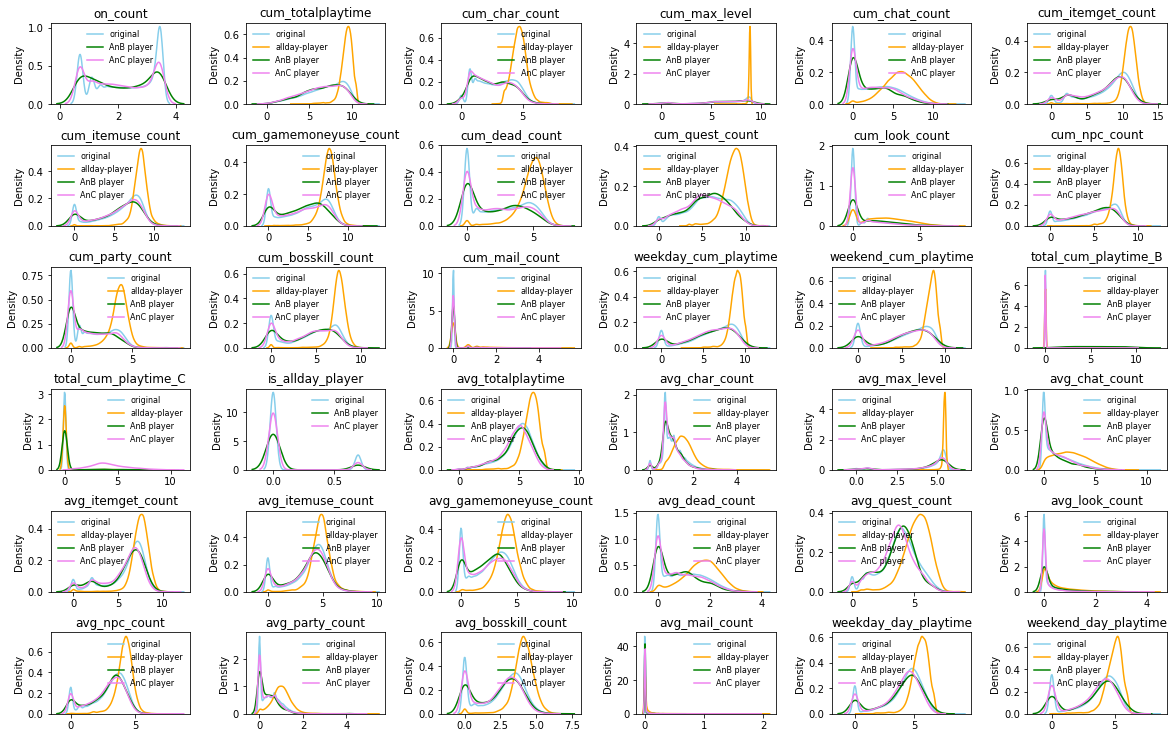

In [125]:
from scipy.stats import norm
import seaborn as sns
data = A.copy()

for col in data.columns:
    data[col] = np.log1p(data[col])
    
i = 1
plt.figure(figsize=(20, 12))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

for col in data.columns:
    plt.subplot(6,6,i)
    sns.distplot(np.array(data[col]), hist=False, color='skyblue', label='original')
    ax1 = sns.distplot(np.array(data[data['is_allday_player'] > 0.0][col]), kde=True, hist=False, color='orange', label='allday-player')
    ax2 = sns.distplot(np.array(data[data['total_cum_playtime_B'] > .0][col]), color='green', kde=True, hist=False, label='AnB player')
    ax3 = sns.distplot(np.array(data[data['total_cum_playtime_C'] > .0][col]), color='violet', kde=True, hist=False, label='AnC player')
    plt.legend(fontsize='8', frameon=False)
    plt.title(str(col))
    i += 1

plt.suptitle("Aggregated scaled data feature distribution", fontsize= 16)
plt.show()

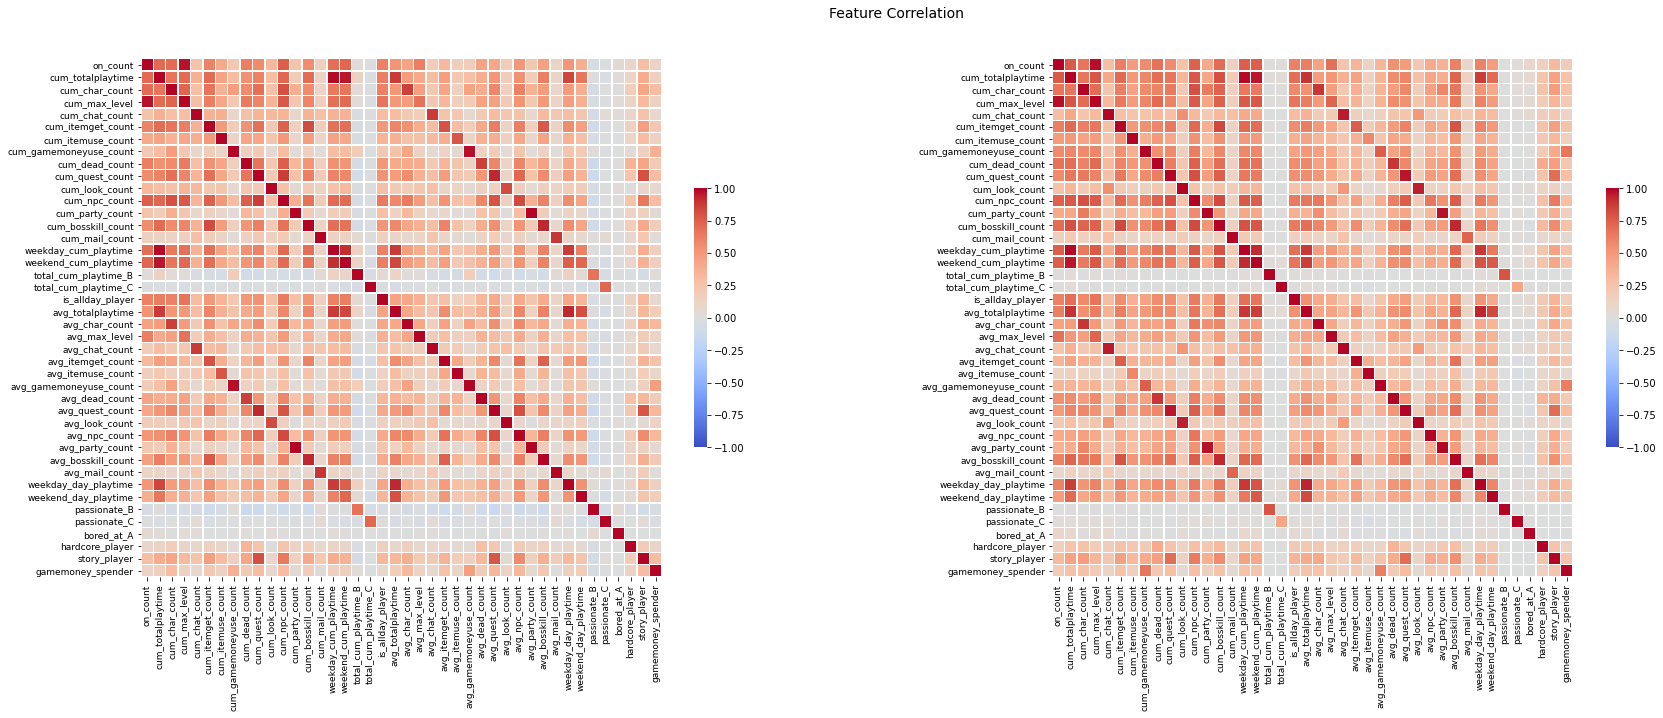

In [127]:
import seaborn as sns

plt.figure(figsize=(28, 9))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(A.loc[user_AnB,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnB,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(A.loc[user_AnC,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnC,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.suptitle("Feature Correlation", fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

In [11]:
A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113408 entries, 6d22b6a82608e8eca368126098d8e5fb0707b9b5937fae6a56c499424cdf0fd4 to ee8dee375c78909881d0420a58ee5022bea07dfd40fcda99d7d3003d3649e11b
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   on_count                113408 non-null  float64
 1   cum_totalplaytime       113408 non-null  float64
 2   cum_char_count          113408 non-null  float64
 3   cum_max_level           113408 non-null  float64
 4   cum_chat_count          113408 non-null  float64
 5   cum_itemget_count       113408 non-null  float64
 6   cum_itemuse_count       113408 non-null  float64
 7   cum_gamemoneyuse_count  113408 non-null  float64
 8   cum_dead_count          113408 non-null  float64
 9   cum_quest_count         113408 non-null  float64
 10  cum_look_count          113408 non-null  float64
 11  cum_npc_count           113408 non-null  float64
 12  cum_party_co

# Step 1. Predict label of 'Passionate player' : Classification

In [136]:
from sklearn.ensemble import RandomForestClassifier

for y_col in ['passionate_B', 'passionate_C']:
    
    if y_col == 'passionate_B':
        train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
        test = A.drop(['total_cum_playtime_B'], axis=1).copy()
        test = test.drop(user_AnB, axis=0)

    if y_col == 'passionate_C':
        train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
        test = A.drop(['total_cum_playtime_C'], axis=1).copy()
        test = test.drop(user_AnC, axis=0)
        
    sc = StandardScaler()

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)
    
    print(Counter(train_y))
    
    ## Oversampling for Class-imbalanced Problem
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)
    
    train_x, train_y = sm.fit_resample(train_x, train_y)
    print("Oversampled:", Counter(train_y))
    
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_x, train_y)
    pred_y = rf.predict(test_x)
    
    A.loc[test.index,y_col] = pred_y

Counter({0.0: 690, 1.0: 231})
Oversampled: Counter({1.0: 690, 0.0: 690})
Counter({0.0: 6714, 1.0: 2243})
Oversampled: Counter({0.0: 6714, 1.0: 6714})


In [137]:
print(Counter(A['passionate_B']))
print(Counter(A['passionate_C']))

Counter({0.0: 90354, 1.0: 23054})
Counter({0.0: 73844, 1.0: 39564})


## Model Candidates

## Step 1-1. Classification

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#from xgboost import plot_importance
#from xgboost import XGBClassifier

rf = RandomForestClassifier()
ab = AdaBoostClassifier(n_estimators=100)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=0)
dt = DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=0)
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#xgb = XGBClassifier(n_estimators=100, learning_rate = 0.01, max_depth = 1)

clf_models = [rf, ab, gb, dt, svm]#, xgb]
clf_names = ['Random Forest', 'Adaboost', 'Gradient Boosting', 'Decision Tree', 'SVM']#, 'xgboost']

K = 5
for model, name in zip(clf_models, clf_names):
    acc = cross_val_score(model, train_x, train_y, scoring='accuracy', cv=K)
    f1 = cross_val_score(model, train_x, train_y, scoring='f1', cv=K)
    print("Accuracy: \t\t %0.4f (+/- %0.4f) [%s]" % (acc.mean(), acc.std(), name))
    print("F1-score: \t\t %0.4f (+/- %0.4f)\n" % (f1.mean(), f1.std()))

Accuracy: 		 0.8197 (+/- 0.0743) [Random Forest]
F1-score: 		 0.8028 (+/- 0.1050)

Accuracy: 		 0.6397 (+/- 0.0661) [Adaboost]
F1-score: 		 0.6231 (+/- 0.1171)

Accuracy: 		 0.5372 (+/- 0.0017) [Gradient Boosting]
F1-score: 		 0.6764 (+/- 0.0013)

Accuracy: 		 0.5900 (+/- 0.0296) [Decision Tree]
F1-score: 		 0.6245 (+/- 0.0319)

Accuracy: 		 0.6047 (+/- 0.0110) [SVM]
F1-score: 		 0.6774 (+/- 0.0132)



# Step 2. Predict probability of 'Passionate player' : regression

## Step 2-1. Regression

Counter({0.0: 690, 1.0: 231})
Oversampled: Counter({1.0: 690, 0.0: 690})
Epoch 1/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.2536 - val_loss: 0.7303
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2374 - val_loss: 0.6641
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2223 - val_loss: 0.6017
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2086 - val_loss: 0.5688
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2023 - val_loss: 0.5509
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2067 - val_loss: 0.5177
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2003 - val_loss: 0.5118
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.1908 - val_loss: 0.4809
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.1942 - val_loss: 0.4762
Epoch 10/1000
8/8 [=========================

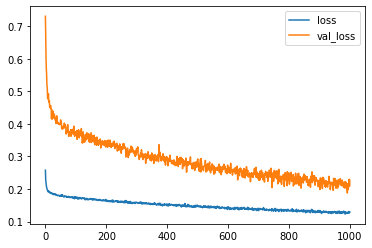

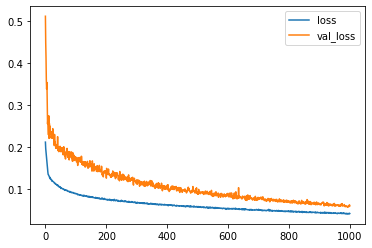

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping


for y_col in ['passionate_B', 'passionate_C']:

    # extract train data: user_AnB or user_AnC data
    if y_col == 'passionate_B':
        train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
        test = A.drop(['total_cum_playtime_B'], axis=1).copy()
        test = test.drop(user_AnB, axis=0)

    if y_col == 'passionate_C':
        train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
        test = A.drop(['total_cum_playtime_C'], axis=1).copy()
        test = test.drop(user_AnC, axis=0)

    sc = StandardScaler()

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)

    print(Counter(train_y))

    ## Oversampling for Class-imbalanced Problem
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)
    train_x, train_y = sm.fit_resample(train_x, train_y)
    print("Oversampled:", Counter(train_y))

    ## Model training with oversampled dataset
    N = train_x.shape[0]
    M = train_x.shape[1]
    train_x = train_x.reshape(N, M, 1).copy()
    
    model = Sequential()
    model.add(Conv1D(128, 8, input_shape=(M, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))

    optimizer = SGD(0.01)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    history = model.fit(x=np.array(train_x),
                      y=np.array(train_y),
                      validation_split = 0.3,
                      batch_size=128,
                      epochs=1000,
                      callbacks=[early_stop])

    losses = pd.DataFrame(history.history)
    losses.plot()
    
    dnn = model
    
    ## Fit and Predict Probability with original dataset
    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)

    N = train_x.shape[0]
    M = train_x.shape[1]
    train_x = train_x.reshape(N, M, 1).copy()

    N = test_x.shape[0]
    M = test_x.shape[1]
    test_x = test_x.reshape(N, M, 1).copy()

    prob_train = dnn.predict(train_x)
    prob_test = dnn.predict(test_x)
    
    ## Scale the prediction between 0 and 1
    msc = MinMaxScaler()
    prob_train = msc.fit_transform(prob_train)
    prob_test = msc.fit_transform(prob_test)
    
    feat_name = str("prob_"+y_col)
    A.loc[test.index, feat_name] = prob_test.reshape(len(test_x),)
    A.loc[train.index, feat_name] = prob_train.reshape(len(train_x),)
    #A.loc[A[A[y_col] == 1.0].index, feat_name] = 1.0

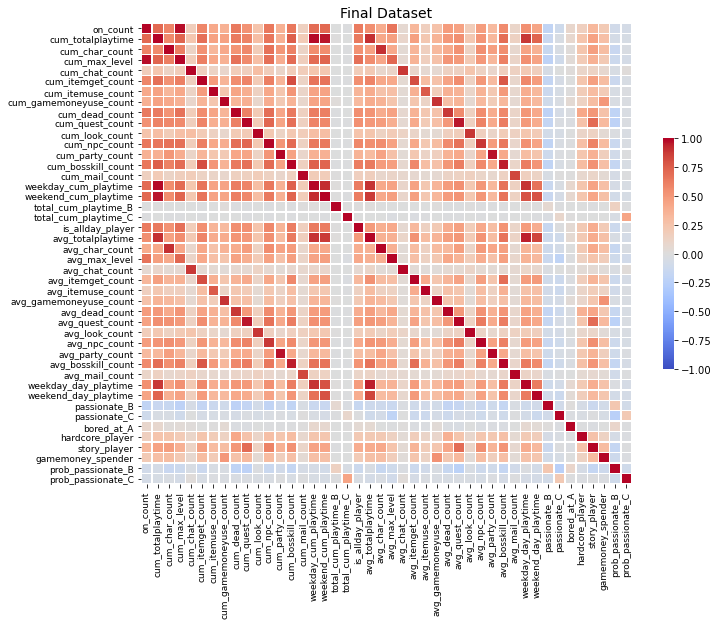

In [139]:
plt.figure(figsize=(11, 8))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
mask = np.triu(np.ones_like(A.corr(), dtype=bool))
sns.heatmap(A.corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("Final Dataset", fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

[]

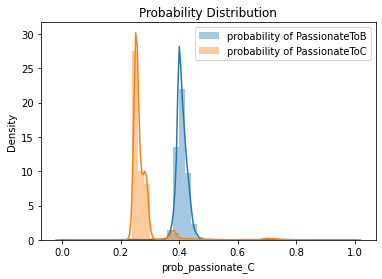

In [140]:
T1 = A['prob_passionate_B'].copy()
T2 = A['prob_passionate_C'].copy()

sns.distplot(T1, label='probability of PassionateToB')
sns.distplot(T2, label='probability of PassionateToC')
plt.legend()
plt.title("Probability Distribution")
plt.plot()

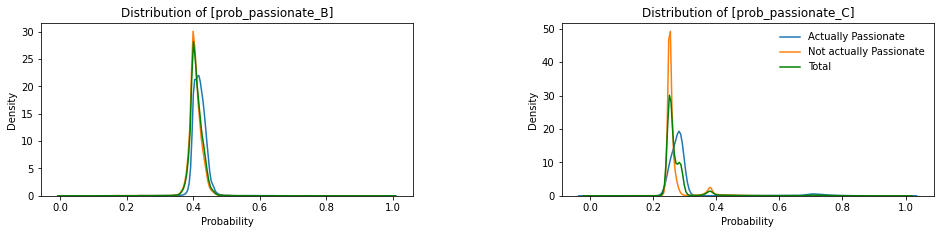

[]

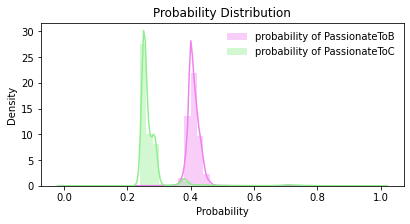

In [30]:
from scipy.stats import norm
import seaborn as sns

plt.figure(figsize=(16, 3))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
sns.distplot(A[A['passionate_B'] == 1.0]['prob_passionate_B'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_B'] != 1.0]['prob_passionate_B'], label='Not actually Passionate', hist=False)
sns.distplot(A['prob_passionate_B'], label='Total', hist=False, color='green')
plt.title("Distribution of [prob_passionate_B]")
plt.xlabel("Probability")

plt.subplot(1,2,2)
sns.distplot(A[A['passionate_C'] == 1.0]['prob_passionate_C'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_C'] != 1.0]['prob_passionate_C'], label='Not actually Passionate', hist=False)
sns.distplot(A['prob_passionate_C'], label='Total', hist=False, color='green')
plt.title("Distribution of [prob_passionate_C]")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Probability")
plt.show()

plt.figure(figsize=(6.5, 3))
sns.distplot(A['prob_passionate_B'], label='probability of PassionateToB', color='violet')
sns.distplot(A['prob_passionate_C'], label='probability of PassionateToC', color='lightgreen')
plt.legend(frameon=False, loc='upper right')
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.plot()

In [168]:
#A.to_csv(os.path.join(data_dir, 'final_A.csv'), header=True, index=True)

In [5]:
A = pd.read_csv(os.path.join(data_dir, 'final_A.csv'))
A.index = np.array(A[A.columns[0]])
A = A.drop([A.columns[0]], axis=1)

In [6]:
A

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C,bored_at_A,hardcore_player,story_player,gamemoney_spender,prob_passionate_B,prob_passionate_C
6d22b6a82608e8eca368126098d8e5fb0707b9b5937fae6a56c499424cdf0fd4,31.0,10978.0,81.0,7230.0,21044.0,30576.0,2866.0,164.0,352.0,511.0,...,251.741935,102.387097,0.0,0.0,0.0,0.0,0.0,0.0,0.343119,0.237071
7a4f634f602ead522697ac53dd363f57ab3d28407e2a8bf2c213a0b0f8ee8603,3.0,363.0,5.0,138.0,0.0,3548.0,473.0,22.0,1.0,267.0,...,121.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.412321,0.250310
6f4098c612af2cd3352c753e46134827a0baa2293bcff83ec6c933ced74f48d3,14.0,3485.0,38.0,1541.0,3.0,28657.0,3144.0,623.0,54.0,1799.0,...,131.428571,117.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.407958,0.250554
90895cf00c6163ebaae72162a84a7db3129e7bb9695a663aabb5f615aab6e7df,30.0,601.0,90.0,1830.0,0.0,9.0,0.0,290.0,0.0,87.0,...,13.966667,6.066667,0.0,0.0,1.0,0.0,0.0,0.0,0.444504,0.238572
e575b8e97d3966112d73460a7e3c986f9b745c0de3f6655f848875bcdf33bbd7,13.0,3422.0,12.0,2523.0,113.0,6912.0,430.0,132.0,32.0,1039.0,...,153.307692,109.923077,0.0,0.0,0.0,0.0,0.0,0.0,0.413575,0.249221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246e378fed76d2c7f21a542d63b14a3c7637976e6d86b1f91a2d3496713743c3,4.0,898.0,5.0,277.0,22.0,5225.0,104.0,47.0,16.0,239.0,...,224.500000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.402974,0.260757
e31c947a43347b8515641250c1afc7a9f0da1cb9cbf38ad3de843b6952071899,31.0,10459.0,149.0,7284.0,147.0,70171.0,5645.0,3449.0,242.0,18123.0,...,199.741935,137.645161,0.0,0.0,0.0,0.0,1.0,0.0,0.394781,0.271724
0d0ce720ec9b38c5e31176f00c687bbf24d6b56627b4f87329662388dce37d04,30.0,26008.0,182.0,7500.0,1432.0,117395.0,7552.0,5106.0,329.0,11498.0,...,599.833333,267.100000,0.0,1.0,0.0,1.0,1.0,1.0,0.391254,0.271867
451c8f1219ce843a543de2f25ffe1da40a7fcf55893834b8ed2b8d2a04750c93,3.0,210.0,4.0,326.0,2.0,2101.0,641.0,21.0,8.0,34.0,...,37.333333,32.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.422850,0.251959


In [171]:
A

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C,bored_at_A,hardcore_player,story_player,gamemoney_spender,prob_passionate_B,prob_passionate_C
6d22b6a82608e8eca368126098d8e5fb0707b9b5937fae6a56c499424cdf0fd4,31.0,10978.0,81.0,7230.0,21044.0,30576.0,2866.0,164.0,352.0,511.0,...,251.741935,102.387097,0.0,0.0,0.0,0.0,0.0,0.0,0.343119,0.237071
7a4f634f602ead522697ac53dd363f57ab3d28407e2a8bf2c213a0b0f8ee8603,3.0,363.0,5.0,138.0,0.0,3548.0,473.0,22.0,1.0,267.0,...,121.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.412321,0.250310
6f4098c612af2cd3352c753e46134827a0baa2293bcff83ec6c933ced74f48d3,14.0,3485.0,38.0,1541.0,3.0,28657.0,3144.0,623.0,54.0,1799.0,...,131.428571,117.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.407958,0.250554
90895cf00c6163ebaae72162a84a7db3129e7bb9695a663aabb5f615aab6e7df,30.0,601.0,90.0,1830.0,0.0,9.0,0.0,290.0,0.0,87.0,...,13.966667,6.066667,0.0,0.0,1.0,0.0,0.0,0.0,0.444504,0.238572
e575b8e97d3966112d73460a7e3c986f9b745c0de3f6655f848875bcdf33bbd7,13.0,3422.0,12.0,2523.0,113.0,6912.0,430.0,132.0,32.0,1039.0,...,153.307692,109.923077,0.0,0.0,0.0,0.0,0.0,0.0,0.413575,0.249221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246e378fed76d2c7f21a542d63b14a3c7637976e6d86b1f91a2d3496713743c3,4.0,898.0,5.0,277.0,22.0,5225.0,104.0,47.0,16.0,239.0,...,224.500000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.402974,0.260757
e31c947a43347b8515641250c1afc7a9f0da1cb9cbf38ad3de843b6952071899,31.0,10459.0,149.0,7284.0,147.0,70171.0,5645.0,3449.0,242.0,18123.0,...,199.741935,137.645161,0.0,0.0,0.0,0.0,1.0,0.0,0.394781,0.271724
0d0ce720ec9b38c5e31176f00c687bbf24d6b56627b4f87329662388dce37d04,30.0,26008.0,182.0,7500.0,1432.0,117395.0,7552.0,5106.0,329.0,11498.0,...,599.833333,267.100000,0.0,1.0,0.0,1.0,1.0,1.0,0.391254,0.271867
451c8f1219ce843a543de2f25ffe1da40a7fcf55893834b8ed2b8d2a04750c93,3.0,210.0,4.0,326.0,2.0,2101.0,641.0,21.0,8.0,34.0,...,37.333333,32.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.422850,0.251959


# Step 3. Predict cumulative play time on other games: regression

In [283]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

for y_col in ['total_cum_playtime_B', 'total_cum_playtime_C']:
    
    sc = StandardScaler()
    
    if y_col == 'total_cum_playtime_B':
        train = A.loc[user_AnB].copy()
        test = A.drop(user_AnB, axis=0)
    elif y_col == 'total_cum_playtime_C':
        train = A.loc[user_AnC].copy()
        test = A.drop(user_AnC, axis=0)

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)
    
    if y_col == 'total_cum_playtime_B':
        
        gdb = GradientBoostingRegressor(random_state=0, n_estimators=500)
        gdb.fit(train_x, train_y)
        pred_train = gdb.predict(train_x)
        pred_test = gdb.predict(test_x)
        
    elif y_col == 'total_cum_playtime_C':
        
        N = train_x.shape[0]
        M = train_x.shape[1]
        train_x = train_x.reshape(N, M, 1).copy()

        N = test_x.shape[0]
        M = test_x.shape[1]
        test_x = test_x.reshape(N, M, 1).copy()
        
        model = Sequential()
        model.add(Conv1D(64, 8, input_shape=(M, 1)))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 8, input_shape=(M, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1))
        optimizer = Adam(.0001)
        model.compile(optimizer=optimizer, loss='mse')

        
        early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
        history = model.fit(x=np.array(train_x),
                          y=np.array(train_y),
                          validation_split = 0.2,
                          batch_size=512,
                          epochs=1000,
                          callbacks=[early_stop])

        losses = pd.DataFrame(history.history)
        #losses.plot()

        cnn = model
        pred_train = cnn.predict(train_x)
        pred_test = cnn.predict(test_x)
    
    # processing result value
    pred_train[pred_train < 0] = 0
    pred_test[pred_test < 0] = 0

    pred_train[pred_train > (31*24*60)] = (31*24*60)
    pred_test[pred_test > (31*24*60)] = (31*24*60)

    feat_name = str("pred_"+y_col)
    A.loc[train.index, feat_name] = pred_train.reshape(len(train_x),)
    A.loc[test.index, feat_name] = pred_test.reshape(len(test_x),)


Epoch 1/1000
14/14 [==============================] - 0s 16ms/step - loss: 1649580.1250 - val_loss: 1270641.7500
Epoch 2/1000
14/14 [==============================] - 0s 9ms/step - loss: 1500123.7000 - val_loss: 1246018.8750
Epoch 3/1000
14/14 [==============================] - 0s 9ms/step - loss: 1806955.9750 - val_loss: 1200693.1250
Epoch 4/1000
14/14 [==============================] - 0s 9ms/step - loss: 1671016.0083 - val_loss: 1185609.8750
Epoch 5/1000
14/14 [==============================] - 0s 9ms/step - loss: 1373220.2333 - val_loss: 1173114.1250
Epoch 6/1000
14/14 [==============================] - 0s 9ms/step - loss: 1692450.2500 - val_loss: 1166495.2500
Epoch 7/1000
14/14 [==============================] - 0s 9ms/step - loss: 1351952.7417 - val_loss: 1158559.3750
Epoch 8/1000
14/14 [==============================] - 0s 9ms/step - loss: 1590827.7917 - val_loss: 1145589.6250
Epoch 9/1000
14/14 [==============================] - 0s 9ms/step - loss: 1524007.5333 - val_loss: 1126

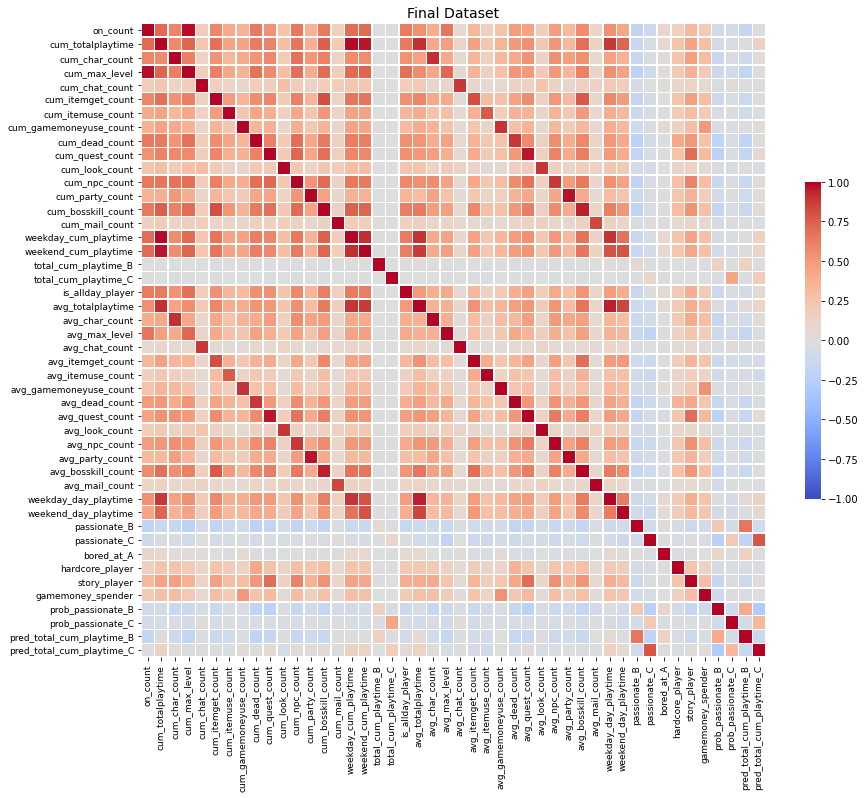

In [258]:
plt.figure(figsize=(14, 11))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
mask = np.triu(np.ones_like(A.corr(), dtype=bool))
sns.heatmap(A.corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("Final Dataset", fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

In [266]:
result = A[['pred_total_cum_playtime_B', 'prob_passionate_B', 'pred_total_cum_playtime_C', 'prob_passionate_C']]

In [281]:
output['A게임 유저ID'] = result.index
output.iloc[:,1:] = np.array(result.iloc[:,:])

,pred_total_cum_playtime_C,total_cum_playtime_C
f5b2f7967e85d2a269357d5ff6dde295baf52169dedaeee153c29ddddaef5c02,25.051863,21.0
d065a555ab75f827e68212e7348a54b935eb73c8f6222a6ddaa1ac954c5a3777,31.632711,23.0
73ddcb1806c9569e4f82142e9da182a70c948644a3385ba664fdebe3fbe70053,39.616898,24.0
b5894710cc814a4fa83e7b7df2568c6d4e3fced8824243a7e609baa64cae0ef1,21.018929,12.0
62b6810afafe3c39913eb16581231c7906e976657f6b7b71c222e2c92e106f71,64.211502,103.0
...,...,...
5b584cd977bfffd41c5ef9190d8d6c2816c733fad81d5fef7c9fbe61e752b3ec,1561.779053,260.0
67a485ef7b25e78474b26ac2d44ba66cbdb1074c97770748f94aeec7af8927e8,31.032082,54.0
84b2d7068be935958a38aa16cd78aede7e62736e18e1f7d4e36903692d7c0fbe,38.785641,18.0
d54702feee5f97f2f1114421ae2957cb4731cab4f80017d61fdf88f21a667222,54.852032,152.0


In [1]:
output

NameError: name 'output' is not defined

In [242]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LeakyReLU

y_col = 'total_cum_playtime_C' #['total_cum_playtime_B', 'total_cum_playtime_C']

sc = StandardScaler()

if y_col == 'total_cum_playtime_B':
    train = A.loc[user_AnB].copy()
    test = A.drop(user_AnB, axis=0)
elif y_col == 'total_cum_playtime_C':
    train = A.loc[user_AnC].copy()
    test = A.drop(user_AnC, axis=0)

train_y = train[y_col].copy()
train_x = train.drop([y_col], axis=1).copy()
train_x = sc.fit_transform(train_x)

test_x = test.drop([y_col], axis=1).copy()
test_x = sc.fit_transform(test_x)

In [165]:
from sklearn import linear_model as lin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR

ridge = lin.RidgeCV(alphas=np.logspace(-6, 6, 13))
lasso = lin.LassoCV()
ard = lin.ARDRegression(compute_score=True)

rfreg = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
adbreg = AdaBoostRegressor(random_state=42, n_estimators=500)
grdreg = GradientBoostingRegressor(random_state=0, n_estimators=100)
#extreg = ExtraTreesRegressor(n_estimators=500, random_state=42)

reg_models = [ridge, lasso, rfreg, adbreg, grdreg, ard]
reg_names = ['Ridge_CV', 
             'Lasso_CV', 
             'Random Forest Regressor', 
             'AdaBoost Regressor', 
             'Gradient Boosting Regressor', 
             #'Extra Trees Regressor', 
             'ARD']
K = 5
for model, name in zip(reg_models, reg_names):
    r2 = cross_val_score(model, train_x, train_y, scoring='r2', cv=K)
    MSE = cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=K)
    RMSE = cross_val_score(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=K)
    
    print("R-square: \t\t %0.4f (+/- %0.4f) \t\t[%s]" % (r2.mean(), r2.std(), name))
    print("MSE: \t\t\t %0.4f (+/- %0.4f)" % (MSE.mean(), MSE.std()))
    print("RMSE: \t\t\t %0.4f (+/- %0.4f)\n" % (RMSE.mean(), RMSE.std()))

R-square: 		 0.1945 (+/- 0.0189) 		[Ridge_CV]
MSE: 			 -1186771.8204 (+/- 215320.2666)
RMSE: 			 -1085.2317 (+/- 95.1002)

R-square: 		 0.1964 (+/- 0.0189) 		[Lasso_CV]
MSE: 			 -1183949.3008 (+/- 214957.0407)
RMSE: 			 -1083.9340 (+/- 95.0594)

R-square: 		 0.1627 (+/- 0.1149) 		[Random Forest Regressor]
MSE: 			 -1215213.1590 (+/- 159947.6219)
RMSE: 			 -1100.0860 (+/- 70.8800)

R-square: 		 -3.4156 (+/- 3.8884) 		[AdaBoost Regressor]
MSE: 			 -6357082.6863 (+/- 5904019.2995)
RMSE: 			 -2316.6723 (+/- 995.0438)

R-square: 		 0.1528 (+/- 0.1430) 		[Gradient Boosting Regressor]
MSE: 			 -1227408.8064 (+/- 181607.2770)
RMSE: 			 -1104.9152 (+/- 81.0631)

R-square: 		 0.1946 (+/- 0.0179) 		[ARD]
MSE: 			 -1185908.3427 (+/- 210362.7659)
RMSE: 			 -1085.0167 (+/- 92.9902)



In [243]:
model1 = lasso
model2 = ard
model1.fit(train_x, train_y)
model2.fit(train_x, train_y)

train_1 = model1.predict(train_x)
pred_1 = model1.predict(test_x)

train_2 = model2.predict(train_x)
pred_2 = model2.predict(test_x)

In [244]:
N = train_x.shape[0]
M = train_x.shape[1]
train_x = train_x.reshape(N, M, 1).copy()

N = test_x.shape[0]
M = test_x.shape[1]
test_x = test_x.reshape(N, M, 1).copy()

Epoch 1/1000
14/14 [==============================] - 0s 15ms/step - loss: 1786713.9167 - val_loss: 1271542.1250
Epoch 2/1000
14/14 [==============================] - 0s 10ms/step - loss: 1811656.5250 - val_loss: 1250110.2500
Epoch 3/1000
14/14 [==============================] - 0s 9ms/step - loss: 1557765.6167 - val_loss: 1202140.1250
Epoch 4/1000
14/14 [==============================] - 0s 9ms/step - loss: 1590343.1792 - val_loss: 1188970.3750
Epoch 5/1000
14/14 [==============================] - 0s 9ms/step - loss: 1480951.4917 - val_loss: 1178570.1250
Epoch 6/1000
14/14 [==============================] - 0s 9ms/step - loss: 1479136.6167 - val_loss: 1176055.8750
Epoch 7/1000
14/14 [==============================] - 0s 9ms/step - loss: 1748614.5417 - val_loss: 1172097.0000
Epoch 8/1000
14/14 [==============================] - 0s 9ms/step - loss: 1730694.3417 - val_loss: 1167046.3750
Epoch 9/1000
14/14 [==============================] - 0s 9ms/step - loss: 1699909.1333 - val_loss: 116

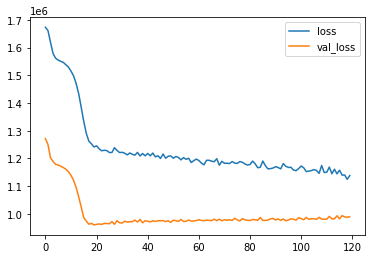

In [245]:
model = Sequential()
model.add(Conv1D(64, 8, input_shape=(M, 1)))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, input_shape=(M, 1)))
model.add(Activation('relu'))
#model.add(Conv1D(128, 8, input_shape=(M, 1)))
#model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1))
optimizer = Adam(.0001)
model.compile(optimizer=optimizer, loss='mse')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history = model.fit(x=np.array(train_x),
                  y=np.array(train_y),
                  validation_split = 0.2,
                  batch_size=512,
                  epochs=1000,
                  callbacks=[early_stop])

losses = pd.DataFrame(history.history)
losses.plot()

cnn = model

In [246]:
train_cnn = cnn.predict(train_x)
pred_cnn = cnn.predict(test_x)

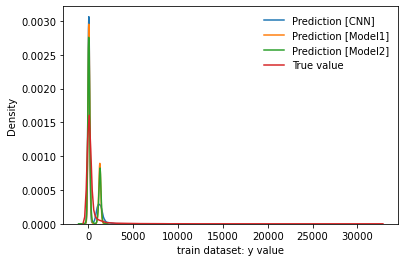

In [248]:
import seaborn as sns

sns.distplot(train_cnn, hist=False, label='Prediction [CNN]')
sns.distplot(train_1, hist=False, label='Prediction [Model1]')
sns.distplot(train_2, hist=False, label='Prediction [Model2]')
sns.distplot(train_y, hist=False, label='True value')
plt.legend(frameon=False)
plt.xlabel("train dataset: y value")
plt.show()

In [249]:
t_cnn = train_cnn.copy()
t_1 = train_1.copy()
t_2 = train_2.copy()

t_cnn[t_cnn < 0] = 0
t_1[t_1 < 0] = 0
t_2[t_2 < 0] = 0

t_cnn[t_cnn > (31*24*60)] = (31*24*60)
t_1[t_1 > (31*24*60)] = (31*24*60)
t_2[t_2 > (31*24*60)] = (31*24*60)

print("[CNN]")
print(t_cnn[:9].reshape(9,).round(2))
print(np.array(train_y[:9]).round(2))
print("------------------------------")
print(t_cnn[-9:].reshape(9,).round(2))
print(np.array(train_y[-9:]).round(2))
print("============================================================")
print("[RF]")
print(t_1[:9].reshape(9,).round(2))
print(np.array(train_y[:9]).round(2))
print("------------------------------")
print(t_1[-9:].reshape(9,).round(2))
print(np.array(train_y[-9:]).round(2))
print("============================================================")
print("[GDB]")
print(t_2[:9].reshape(9,).round(2))
print(np.array(train_y[:9]).round(2))
print("------------------------------")
print(t_2[-9:].reshape(9,).round(2))
print(np.array(train_y[-9:]).round(2))

[CNN]
[  26.61   37.51   45.31   16.15   20.41   51.54  930.23   38.55 1352.39]
[   21.    23.    24.    12.   103.    37.   273.    18. 11884.]
------------------------------
[  66.03   21.     27.05   43.12 1500.67   38.83   25.54   46.43   22.02]
[ 53. 161.  44. 148. 260.  54.  18. 152.  33.]
[RF]
[  94.3    33.9    74.3    47.53  205.46    1.32 1076.65  102.71 1268.73]
[   21.    23.    24.    12.   103.    37.   273.    18. 11884.]
------------------------------
[   0.     30.37   24.91   11.61 1391.01   60.79  122.08    0.    175.7 ]
[ 53. 161.  44. 148. 260.  54.  18. 152.  33.]
[GDB]
[  49.21   40.73  109.44   22.66  404.6     0.   1049.88  106.18 1294.05]
[   21.    23.    24.    12.   103.    37.   273.    18. 11884.]
------------------------------
[   0.      7.87  121.94   16.55 1430.49   64.45  121.74    0.    165.57]
[ 53. 161.  44. 148. 260.  54.  18. 152.  33.]


In [250]:
from sklearn.metrics import mean_absolute_error as MAE

print("CNN train data MAE:", MAE(t_cnn, train_y))
print("MODEL1 train data MAE:", MAE(t_1, train_y))
print("MODEL2 train data MAE:", MAE(t_2, train_y))
print("\nCNN train data MAE:", MAE(train_cnn, train_y))
print("MODEL1 train data MAE:", MAE(train_1, train_y))
print("MODEL2 train data MAE:", MAE(train_2, train_y))

CNN train data MAE: 315.7751729107534
MODEL1 train data MAE: 334.17846973663325
MODEL2 train data MAE: 339.5486936824771

CNN train data MAE: 315.79038404392185
MODEL1 train data MAE: 336.1152971823654
MODEL2 train data MAE: 345.4278461593442


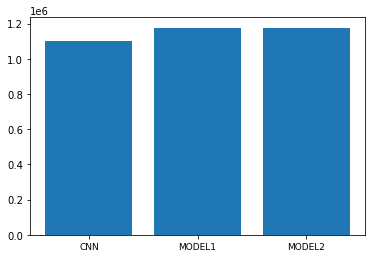


CNN train data error: 1098538.7243060211
MODEL1 train data error: 1176154.1725969538
MODEL2 train data error: 1173310.1119412577 



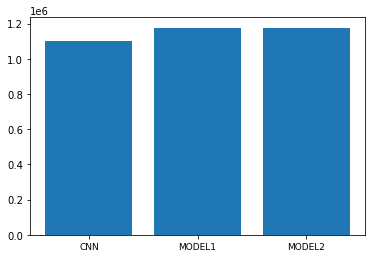


CNN train data error: 1098539.8944218701
MODEL1 train data error: 1176541.686803108
MODEL2 train data error: 1174515.2794562902 



In [251]:
from sklearn.metrics import mean_squared_error as MSE
plt.bar(np.arange(3), [MSE(t_cnn, train_y), MSE(t_1, train_y), MSE(t_2, train_y)])
plt.xticks(np.arange(3), ['CNN', 'MODEL1', 'MODEL2'], fontsize=9)
plt.show()
print("\nCNN train data error:", MSE(t_cnn, train_y))
print("MODEL1 train data error:", MSE(t_1, train_y))
print("MODEL2 train data error:", MSE(t_2, train_y), "\n")

from sklearn.metrics import mean_squared_error as MSE
plt.bar(np.arange(3), [MSE(train_cnn, train_y), MSE(train_1, train_y), MSE(train_2, train_y)])
plt.xticks(np.arange(3), ['CNN', 'MODEL1', 'MODEL2'], fontsize=9)
plt.show()
print("\nCNN train data error:", MSE(train_cnn, train_y))
print("MODEL1 train data error:", MSE(train_1, train_y))
print("MODEL2 train data error:", MSE(train_2, train_y), "\n")


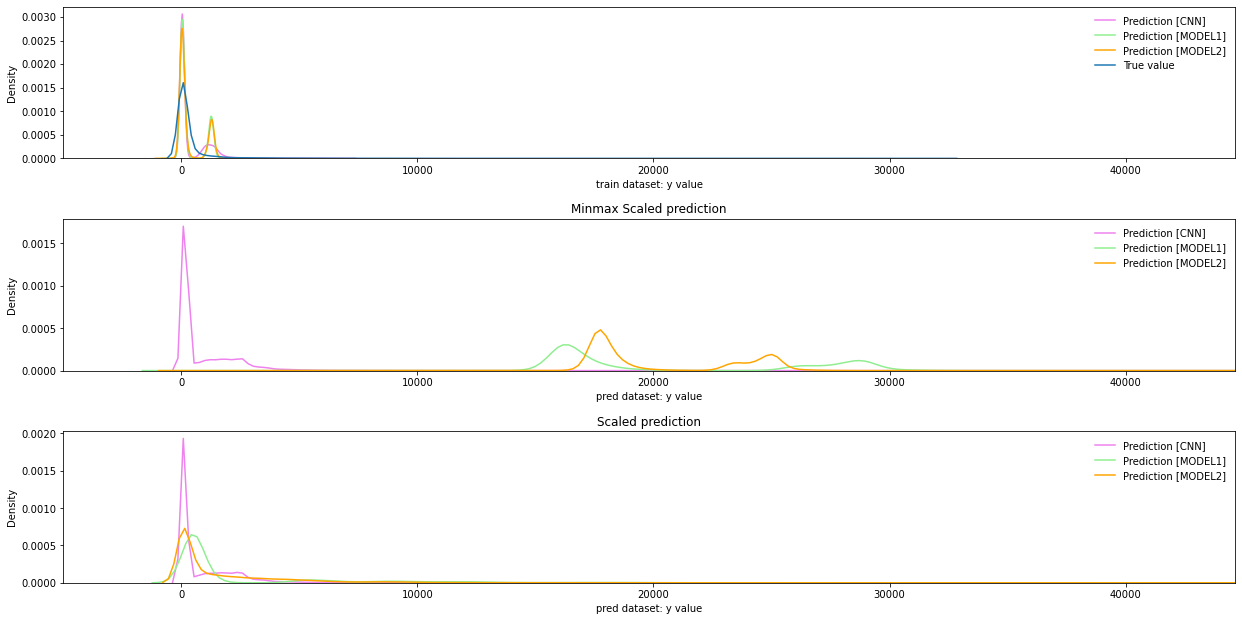

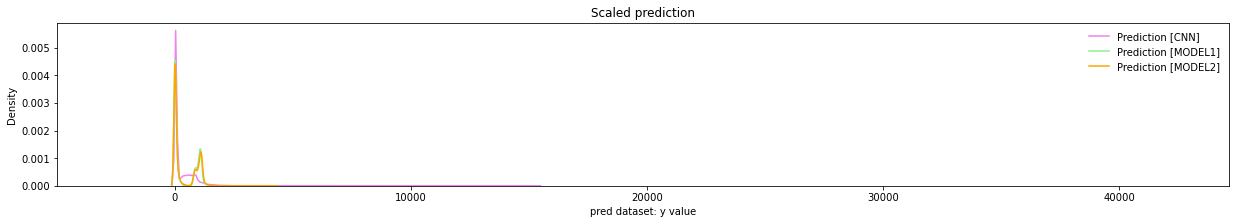

In [252]:
plt.figure(figsize=(21, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(3,1,1)
sns.distplot(train_cnn, hist=False, label='Prediction [CNN]', color='violet')
sns.distplot(train_1, hist=False, label='Prediction [MODEL1]', color='lightgreen')
sns.distplot(train_2, hist=False, label='Prediction [MODEL2]', color='orange')
sns.distplot(train_y, hist=False, label='True value')#, color='lightgray')
plt.legend(frameon=False)
plt.xlabel("train dataset: y value")
plt.xlim((-5000, (31*24*60)))
#plt.show()

plt.subplot(3,1,2)
sns.distplot((pred_cnn-min(pred_cnn))/(max(pred_cnn)-min(pred_cnn))*(31*24*60), hist=False, label='Prediction [CNN]', color='violet')
sns.distplot((pred_1-min(pred_1))/(max(pred_1)-min(pred_1))*(31*24*60), hist=False, label='Prediction [MODEL1]', color='lightgreen')
sns.distplot((pred_2-min(pred_2))/(max(pred_2)-min(pred_2))*(31*24*60), hist=False, label='Prediction [MODEL2]', color='orange')
plt.legend(frameon=False)
plt.xlabel("pred dataset: y value")
plt.title("Minmax Scaled prediction")
plt.xlim((-5000, (31*24*60)))
#plt.show()

t_cnn = ((31*24*60)*pred_cnn)/max(pred_cnn)
t_1 = ((31*24*60)*pred_rf)/max(pred_rf)
t_2 = ((31*24*60)*pred_gd)/max(pred_gd)
t_cnn[t_cnn < 0] = 0
t_1[t_1 < 0] = 0
t_2[t_2 < 0] = 0

plt.subplot(3,1,3)
sns.distplot(t_cnn, hist=False, label='Prediction [CNN]', color='violet')
sns.distplot(t_1, hist=False, label='Prediction [MODEL1]', color='lightgreen')
sns.distplot(t_2, hist=False, label='Prediction [MODEL2]', color='orange')
plt.legend(frameon=False)
plt.title("Scaled prediction")
plt.xlabel("pred dataset: y value")
plt.xlim((-5000, (31*24*60)))
plt.show()

t_cnn = pred_cnn.copy()
t_1 = pred_1.copy()
t_2 = pred_2.copy()
t_cnn[t_cnn < 0] = 0
t_1[t_1 < 0] = 0
t_2[t_2 < 0] = 0
t_cnn[t_cnn > (31*24*60)] = (31*24*60)
t_1[t_1 > (31*24*60)] = (31*24*60)
t_2[t_2 > (31*24*60)] = (31*24*60)

plt.figure(figsize=(21, 3))

sns.distplot(t_cnn, hist=False, label='Prediction [CNN]', color='violet')
sns.distplot(t_1, hist=False, label='Prediction [MODEL1]', color='lightgreen')
sns.distplot(t_2, hist=False, label='Prediction [MODEL2]', color='orange')
plt.legend(frameon=False)
plt.title("Scaled prediction")
plt.xlabel("pred dataset: y value")
plt.xlim((-5000, (31*24*60)))
plt.show()

32261.0

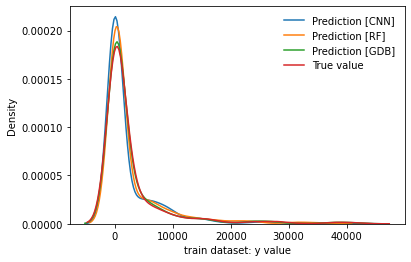

In [104]:
import seaborn as sns

sns.distplot(train_cnn, hist=False, label='Prediction [CNN]')
sns.distplot(train_rf, hist=False, label='Prediction [RF]')
sns.distplot(train_gd, hist=False, label='Prediction [GDB]')
sns.distplot(train_y, hist=False, label='True value')
plt.legend(frameon=False)
plt.xlabel("train dataset: y value")
plt.show()

In [132]:
t_cnn = train_cnn.copy()
t_rf = train_rf.copy()
t_gd = train_gd.copy()

t_cnn[t_cnn < 0] = 0
t_rf[t_rf < 0] = 0
t_gd[t_gd < 0] = 0

t_cnn[t_cnn > (31*24*60)] = (31*24*60)
t_rf[t_rf > (31*24*60)] = (31*24*60)
t_gd[t_gd > (31*24*60)] = (31*24*60)

print("[CNN]")
print(t_cnn[:9].reshape(9,).round(2))
print(np.array(train_y[:9]).round(2))
print("------------------------------")
print(t_cnn[-9:].reshape(9,).round(2))
print(np.array(train_y[-9:]).round(2))
print("============================================================")
print("[RF]")
print(t_rf[:9].reshape(9,).round(2))
print(np.array(train_y[:9]).round(2))
print("------------------------------")
print(t_rf[-9:].reshape(9,).round(2))
print(np.array(train_y[-9:]).round(2))
print("============================================================")
print("[GDB]")
print(t_gd[:9].reshape(9,).round(2))
print(np.array(train_y[:9]).round(2))
print("------------------------------")
print(t_gd[-9:].reshape(9,).round(2))
print(np.array(train_y[-9:]).round(2))

[CNN]
[   0.      0.     93.7     0.    150.8  8183.01 1003.71    0.      0.  ]
[  24.    1.   30.   24.  408. 3277. 1916.    9.    1.]
------------------------------
[   0.    249.77   59.05  224.36    0.   1036.01    0.   8392.97 7247.56]
[2219.   16.  256. 1421.  116.  190.    2. 2719. 9334.]
[RF]
[ 141.62   52.96   81.44  125.78  422.88 5884.48 1223.76  105.86  166.4 ]
[  24.    1.   30.   24.  408. 3277. 1916.    9.    1.]
------------------------------
[1413.54   97.42  237.64 1011.86  126.2   429.86   69.72 2772.94 8967.4 ]
[2219.   16.  256. 1421.  116.  190.    2. 2719. 9334.]
[GDB]
[ 269.07  137.4   242.61   40.93  473.06 3981.54 1031.21  406.21   42.59]
[  24.    1.   30.   24.  408. 3277. 1916.    9.    1.]
------------------------------
[1708.79    0.    266.51  812.48   70.99  316.96    0.   3352.23 8849.22]
[2219.   16.  256. 1421.  116.  190.    2. 2719. 9334.]


CNN train data error: 9229002.53711696
RF train data error: 1892932.3365124862
GDB train data error: 107566.09235116372


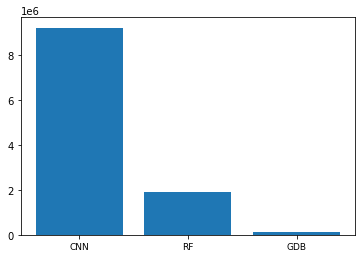

CNN train data error: 9265368.298351249
RF train data error: 1892932.3365124862
GDB train data error: 109410.14963283269


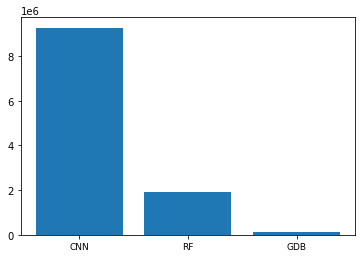

In [148]:
from sklearn.metrics import mean_squared_error as MSE
print("CNN train data error:", MSE(t_cnn, train_y))
print("RF train data error:", MSE(t_rf, train_y))
print("GDB train data error:", MSE(t_gd, train_y))

plt.bar(np.arange(3), [MSE(t_cnn, train_y), MSE(t_rf, train_y), MSE(t_gd, train_y)])
plt.xticks(np.arange(3), ['CNN', 'RF', 'GDB'], fontsize=9)
plt.show()

from sklearn.metrics import mean_squared_error as MSE
print("CNN train data error:", MSE(train_cnn, train_y))
print("RF train data error:", MSE(train_rf, train_y))
print("GDB train data error:", MSE(train_gd, train_y))

plt.bar(np.arange(3), [MSE(train_cnn, train_y), MSE(train_rf, train_y), MSE(train_gd, train_y)])
plt.xticks(np.arange(3), ['CNN', 'RF', 'GDB'], fontsize=9)
plt.show()

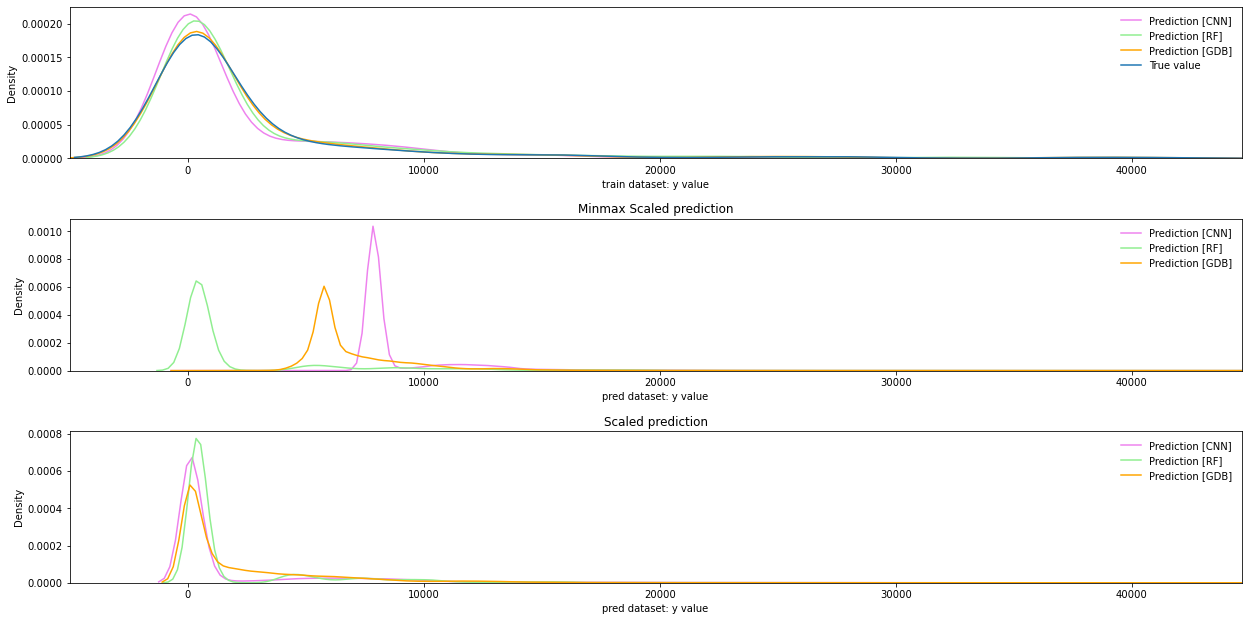

In [154]:
plt.figure(figsize=(21, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(3,1,1)
sns.distplot(train_cnn, hist=False, label='Prediction [CNN]', color='violet')
sns.distplot(train_rf, hist=False, label='Prediction [RF]', color='lightgreen')
sns.distplot(train_gd, hist=False, label='Prediction [GDB]', color='orange')
sns.distplot(train_y, hist=False, label='True value')#, color='lightgray')
plt.legend(frameon=False)
plt.xlabel("train dataset: y value")
plt.xlim((-5000, (31*24*60)))
#plt.show()

plt.subplot(3,1,2)
sns.distplot((pred_cnn-min(pred_cnn))/(max(pred_cnn)-min(pred_cnn))*(31*24*60), hist=False, label='Prediction [CNN]', color='violet')
sns.distplot((pred_rf-min(pred_rf))/(max(pred_rf)-min(pred_rf))*(31*24*60), hist=False, label='Prediction [RF]', color='lightgreen')
sns.distplot((pred_gd-min(pred_gd))/(max(pred_gd)-min(pred_gd))*(31*24*60), hist=False, label='Prediction [GDB]', color='orange')
plt.legend(frameon=False)
plt.xlabel("pred dataset: y value")
plt.title("Minmax Scaled prediction")
plt.xlim((-5000, (31*24*60)))
#plt.show()

#t_cnn = ((31*24*60)*pred_cnn)/max(pred_cnn)
#t_rf = ((31*24*60)*pred_rf)/max(pred_rf)
#t_gd = ((31*24*60)*pred_gd)/max(pred_gd)
#t_cnn[t_cnn < 0] = 0
#t_rf[t_rf < 0] = 0
#t_gd[t_gd < 0] = 0

t_cnn = pred_cnn.copy()
t_rf = pred_rf.copy()
t_gd = pred_gd.copy()
t_cnn[t_cnn < 0] = 0
t_rf[t_rf < 0] = 0
t_gd[t_gd < 0] = 0
t_cnn[t_cnn > (31*24*60)] = (31*24*60)
t_rf[t_rf > (31*24*60)] = (31*24*60)
t_gd[t_gd > (31*24*60)] = (31*24*60)

plt.subplot(3,1,3)
sns.distplot(t_cnn, hist=False, label='Prediction [CNN]', color='violet')
sns.distplot(t_rf, hist=False, label='Prediction [RF]', color='lightgreen')
sns.distplot(t_gd, hist=False, label='Prediction [GDB]', color='orange')
plt.legend(frameon=False)
plt.title("Scaled prediction")
plt.xlabel("pred dataset: y value")
plt.xlim((-5000, (31*24*60)))
plt.show()

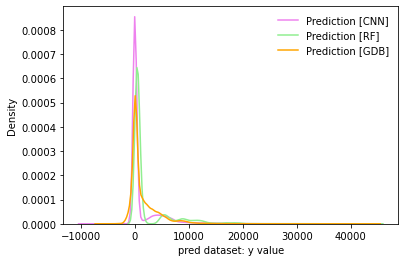

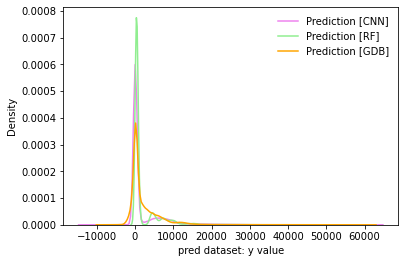

In [108]:
sns.distplot(((31*24*60)*pred_cnn)/max(pred_cnn), hist=False, label='Prediction [CNN]', color='violet')
sns.distplot(((31*24*60)*pred_rf)/max(pred_rf), hist=False, label='Prediction [RF]', color='lightgreen')
sns.distplot(((31*24*60)*pred_gd)/max(pred_gd), hist=False, label='Prediction [GDB]', color='orange')
plt.legend(frameon=False)
plt.xlabel("pred dataset: y value")
plt.show()


sns.distplot(pred_cnn, hist=False, label='Prediction [CNN]', color='violet')
sns.distplot(pred_rf, hist=False, label='Prediction [RF]', color='lightgreen')
sns.distplot(pred_gd, hist=False, label='Prediction [GDB]', color='orange')
plt.legend(frameon=False)
plt.xlabel("pred dataset: y value")
plt.show()

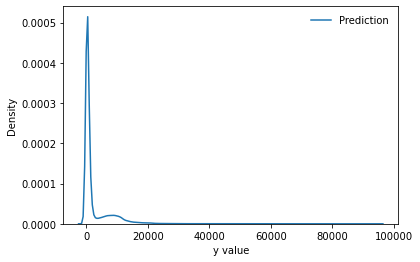

In [65]:
sns.distplot(prob_test, hist=False, label='Prediction')
plt.legend(frameon=False)
plt.xlabel("y value")
plt.show()

<AxesSubplot:ylabel='Density'>

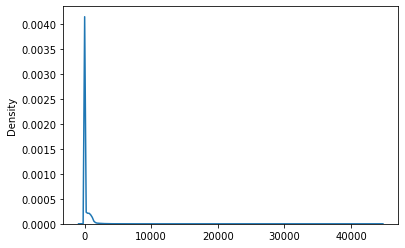

In [46]:
max(prob_test)

array([349222.22], dtype=float32)

In [ ]:
prob_test - max(prob_test)

In [47]:
349222/31

11265.225806451614

In [50]:
((31*24*60)*prob_test)/max(prob_test)

array([[ 51.008335],
       [931.3319  ],
       [422.97324 ],
       ...,
       [ 13.792825],
       [ 39.109547],
       [ 77.352455]], dtype=float32)

In [ ]:
A[A['prob_passionate_B'] > 0.0]['prob_passionate_B']

In [32]:
#for y_col in ['passionate_B', 'passionate_C']:
y_col = 'passionate_C'

# extract train data: user_AnB or user_AnC data
if y_col == 'passionate_B':
    train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
    test = A.drop(['total_cum_playtime_B'], axis=1).copy()
    test = test.drop(user_AnB, axis=0)

if y_col == 'passionate_C':
    train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
    test = A.drop(['total_cum_playtime_C'], axis=1).copy()
    test = test.drop(user_AnC, axis=0)

sc = StandardScaler()

train_y = train[y_col]
train_x = train.drop([y_col], axis=1)
train_x = sc.fit_transform(train_x)

test_x = test.drop([y_col], axis=1)
test_x = sc.fit_transform(test_x)

print(Counter(train_y))

## Oversampling for Class-imbalanced Problem
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42, k_neighbors=7)
train_x, train_y = sm.fit_resample(train_x, train_y)
print("Oversampled:", Counter(train_y))

N = train_x.shape[0]
M = train_x.shape[1]
train_x = train_x.reshape(N, M, 1).copy()

N = test_x.shape[0]
M = test_x.shape[1]
test_x = test_x.reshape(N, M, 1).copy()

Counter({0.0: 6714, 1.0: 2243})
Oversampled: Counter({0.0: 6714, 1.0: 6714})


Epoch 1/1000
74/74 [==============================] - 1s 5ms/step - loss: 0.2364 - val_loss: 0.4507
Epoch 2/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2058 - val_loss: 0.4805
Epoch 3/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2140 - val_loss: 0.4649
Epoch 4/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2013 - val_loss: 0.4850
Epoch 5/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2012 - val_loss: 0.4364
Epoch 6/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2002 - val_loss: 0.4602
Epoch 7/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2019 - val_loss: 0.4410
Epoch 8/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2047 - val_loss: 0.5082
Epoch 9/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.1998 - val_loss: 0.4788
Epoch 10/1000
74/74 [==============================] - 0s 4ms/step - loss: 0.2031 - val_loss: 0.4587

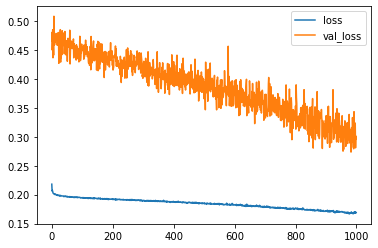

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

#model = Sequential()
#model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(2048,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1024,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1))

#model = Sequential()
#model.add(Conv1D(128, 8, input_shape=(train_x.shape[1], 1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Conv1D(256, 5))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Conv1D(128 ,3))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(GlobalAveragePooling1D())
#model.add(Flatten())                 
#model.add(Dense(1))

model = Sequential()
model.add(Conv1D(128, 8, input_shape=(M, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1))

optimizer = SGD(0.01)
#optimizer = Adam(.01)
model.compile(optimizer=optimizer, loss='mse')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history = model.fit(x=np.array(train_x),
                  y=np.array(train_y),
                  validation_split = 0.3,
                  batch_size=128,
                  epochs=1000,
                  callbacks=[early_stop])

losses = pd.DataFrame(history.history)
losses.plot()

dnn = model

In [35]:
# extract train data: user_AnB or user_AnC data
if y_col == 'passionate_B':
    train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
    test = A.drop(['total_cum_playtime_B'], axis=1).copy()
    test = test.drop(user_AnB, axis=0)

if y_col == 'passionate_C':
    train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
    test = A.drop(['total_cum_playtime_C'], axis=1).copy()
    test = test.drop(user_AnC, axis=0)

sc = StandardScaler()

train_y = train[y_col]
train_x = train.drop([y_col], axis=1)
train_x = sc.fit_transform(train_x)

test_x = test.drop([y_col], axis=1)
test_x = sc.fit_transform(test_x)

N = train_x.shape[0]
M = train_x.shape[1]
train_x = train_x.reshape(N, M, 1).copy()

N = test_x.shape[0]
M = test_x.shape[1]
test_x = test_x.reshape(N, M, 1).copy()

prob_train = dnn.predict(train_x)
prob_test = dnn.predict(test_x)

msc = MinMaxScaler()
prob_train = msc.fit_transform(prob_train)
prob_test = msc.fit_transform(prob_test)

print(prob_train[:10].reshape(10,).round(2))
print(np.array(train_y[:10]).round(2))
print("------------------------------")
print(prob_train[-10:].reshape(10,).round(2))
print(np.array(train_y[-10:]).round(2))

[0.38 0.56 0.49 0.51 0.58 0.5  0.49 0.58 0.43 0.53]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
------------------------------
[0.58 0.4  0.56 0.34 0.64 0.58 0.46 0.51 0.6  0.62]
[0. 0. 0. 0. 1. 0. 0. 1. 1. 1.]


In [286]:
feat_name = str("prob_"+y_col)
A.loc[test.index, feat_name] = prob_test.reshape(len(test_x),)
A.loc[train.index, feat_name] = prob_train.reshape(len(train_x),)
A.loc[A[A[y_col] == 1.0].index, feat_name] = 1.0

In [25]:
np.array(train_y[:10])

array([  24.,    1.,   30.,   24.,  408., 3277., 1916.,    9.,    1.,
       1678.])

In [26]:
print(prob_train[:10].reshape(10,).round(2))
print(np.array(train_y[:10]).round(2))
print("------------------------------")
print(prob_train[-10:].reshape(10,).round(2))
print(np.array(train_y[-10:]).round(2))

[ 557.93  341.2   238.82  312.47  272.48 8952.05  352.77  324.68  376.98
  359.92]
[  24.    1.   30.   24.  408. 3277. 1916.    9.    1. 1678.]
------------------------------
[ 159.63   59.74  352.77  332.8   379.86  287.25  250.1   182.77 7095.85
 5764.9 ]
[  30. 2219.   16.  256. 1421.  116.  190.    2. 2719. 9334.]


In [173]:
prob_y[-10:].reshape(10,).round(2)

array([0.3 , 0.31, 0.36, 0.15, 0.16, 0.32, 0.31, 0.29, 0.31, 0.26],
      dtype=float32)

In [167]:
np.array(A.loc[test.index,:][-10:][y_col])

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

In [168]:
prob_y[-10:].reshape(10,).round(2)

array([ 0.06,  0.22,  0.31, -0.01, -0.  ,  0.22,  0.23, -0.06,  0.27,
        0.19], dtype=float32)

In [98]:
np.array(train_y[:10])

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [99]:
prob_y[:10].reshape(10,).round(2)

array([0.52, 0.04, 0.03, 0.06, 0.07, 0.07, 0.54, 0.04, 0.06, 0.07],
      dtype=float32)

In [1]:
A[y_col] - prob_y.reshape(len(test),)

NameError: name 'A' is not defined

In [ ]:
feat_name = str("prob_"+y_col)
A.loc[test.index, feat_name] = prob_y.reshape(len(test),)

if y_col == 'passionate_C':
    A.loc[user_AnC, feat_name] = A.loc[user_AnC, y_col]
if y_col == 'passionate_B':
    A.loc[user_AnB, feat_name] = A.loc[user_AnB, y_col]

In [298]:
A[A['passionate_C'] == 1]

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_maxlevel,avg_quest,bored_at_A,avg_dead,hardcore_player,avg_npc,story_player,avg_gamemoneyuse,gamemoney_spender,prob_passionate_C
3357233ff933db12de31d5a7c8857cbb7710bafbb11297050157619549ac0bf0,4.0,318.0,6.0,452.0,0.0,2419.0,317.0,32.0,1.0,47.0,...,113.000000,11.750000,0.0,0.250000,0.0,18.500000,0.0,8.000000,0.0,1.000000
b8e8207344e3f5df7727252baf416238da06cc150fb37831459c47fdca857b85,8.0,1023.0,9.0,1028.0,121.0,5354.0,631.0,134.0,12.0,722.0,...,128.500000,90.250000,0.0,1.500000,0.0,24.375000,0.0,16.750000,0.0,1.000000
93aacae84e408fbb2a4be6870f789e59b852de99bf242fea94c35f779d345614,7.0,655.0,11.0,1439.0,15.0,3191.0,276.0,188.0,13.0,132.0,...,205.571429,18.857143,0.0,1.857143,0.0,19.285714,0.0,26.857143,0.0,1.000000
bd3c73b57b75c9bd1c9e469c8d308d55fc7e8ec2caaf3fdc4000df30f8d61e62,6.0,718.0,7.0,814.0,1.0,5367.0,1566.0,16.0,11.0,170.0,...,135.666667,28.333333,0.0,1.833333,0.0,9.833333,0.0,2.666667,0.0,0.415025
d0e055d44ea0ce4e590f0f5c5ec1b3c0e6174833e246e5aa91d095a2823bb727,8.0,743.0,8.0,594.0,12.0,2306.0,409.0,9.0,10.0,204.0,...,74.250000,25.500000,0.0,1.250000,0.0,9.375000,0.0,1.125000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c1fb8a8c853bff8b5ac060f135fc0376ebc3cf4b1bedc3ed38bd07080a6b2a,24.0,2320.0,54.0,4998.0,92.0,12715.0,1004.0,769.0,70.0,1616.0,...,208.250000,67.333333,0.0,2.916667,0.0,47.541667,0.0,32.041667,0.0,1.000000
664ce897ea206331fb48b1dff5a4e34593ea4eab294efbbe4d220c42f9204a00,31.0,4520.0,40.0,6759.0,109.0,19912.0,1203.0,1095.0,117.0,456.0,...,218.032258,14.709677,0.0,3.774194,0.0,29.290323,0.0,35.322581,0.0,0.054133
d861a1aa31f4a25803281407f0304d6294eab75c5d4aeeb40971e24978f0d0d6,4.0,687.0,4.0,493.0,0.0,3119.0,192.0,15.0,8.0,158.0,...,123.250000,39.500000,0.0,2.000000,0.0,21.750000,0.0,3.750000,0.0,0.061510
84408d18434de454f3d34109af01b003c0bd2a65a8306785ff8f27a5d51895f5,4.0,616.0,3.0,99.0,0.0,1104.0,101.0,3.0,9.0,124.0,...,24.750000,31.000000,0.0,2.250000,0.0,8.750000,0.0,0.750000,0.0,0.191057


In [299]:
A.loc[user_AnC, y_col]

2a67b841db6cf75e15d6a359cc9fd0f9cafe158019669d4355a20b9e5ba58a65    0.0
1b5e04571f5597933ce167b2524e0887175aa898ea504b7d69c0d0ac6c0edca2    0.0
92dcab4ec69ba26ef635cda9662f3f427f8ea38870f850136be444076a7ccccd    0.0
8be4791d797d4278600de6e370420a4ee8f0d97dca9b56aadd80f3e5a2a85c71    0.0
b096732c9741fb4e272d3a314f8efeae060ae9edf9e9b7fd825f85de3d11ee91    0.0
                                                                   ... 
c1c2f93cab5c32a5f4b83a7b16c2a4029ad8afb0916604fdb2a60cd93d30b1b0    0.0
4ac613abfb71a1dc8a5a93028ff1e533d23d305e0bc2c1ebbc4d095af11a1b86    0.0
464ffffe4b7a27be1b09c5a0221b2e348c38e3ef3bd1166c8110cca643d38e73    0.0
08b74acdd5653e4f2b273b5d1dd21e92293cc3596c0897f0930e73e6e34dbb04    0.0
bd84d8192243e18214658a26f32500ba1d45c972277b671dfeddf50c2ac66cb0    0.0
Name: passionate_C, Length: 8957, dtype: float64

In [ ]:
from sklearn import linear_model as lin
from sklearn.model_selection import cross_val_score

linReg = lin.LinearRegression()
ridge = lin.Ridge(alpha=.5)
lasso = lin.Lasso(alpha=0.1)
cv_Ridge = lin.RidgeCV(alphas=np.logspace(-6, 6, 13))
cv_Lasso = lin.LassoCV()
ard = lin.ARDRegression(compute_score=True)

from sklearn.ensemble import RandomForestRegressor
rfReg = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)
reg_models = [cv_Lasso, rfReg, ard]
reg_names = ['Lasso_CV', 
             'Random Forest Regression', 
             'ARD']
K = 5
for model, name in zip(reg_models, reg_names):
    r2 = cross_val_score(model, train_x, train_y, scoring='r2', cv=K)
    MSE = cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=K)
    RMSE = cross_val_score(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=K)
    
    print("R-square: \t\t %0.4f (+/- %0.4f) [%s]" % (r2.mean(), r2.std(), name))
    print("MSE: \t\t\t %0.4f (+/- %0.4f)" % (MSE.mean(), MSE.std()))
    print("RMSE: \t\t\t %0.4f (+/- %0.4f)\n" % (RMSE.mean(), RMSE.std()))

In [ ]:
model = Sequential()
model.add(Conv1D(64, 8, input_shape=(M, 1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, input_shape=(M, 1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, input_shape=(M, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1))
optimizer = Adam(.001)
model.compile(optimizer=optimizer, loss='mse')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history = model.fit(x=np.array(train_x),
                  y=np.array(train_y),
                  validation_split = 0.2,
                  batch_size=128,
                  epochs=1000,
                  callbacks=[early_stop])

losses = pd.DataFrame(history.history)
losses.plot()